# Deep Q-learning
Refer to the lecture note `8DQN.pdf`

## To run jupyter without remote redering (e.g. on a local machine), execute jupyter by:
`jupyter notebook --ip=YOUR_IP --notebook-dir YOUR_WORKING_DIR`

## To run jupyter with remote redering (e.g. on a remote machine), execute jupyter by:
`xvfb-run -s "-screen 0 600x400x24" jupyter notebook --ip=YOUR_IP --notebook-dir YOUR_WORKING_DIR`

## Important argument
`do_render`: set ```True``` to render (visualize) the environment on the notebook for each step

In [ ]:
# DQN 단점
# action이 continuos인 경우 어렵다
# epsilon greedy 사용 일정 수준의 확률로 탐험 -> epsilon에 영향을 받음

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

import gym
import random
import numpy as np
from collections import deque

In [2]:
l = deque(maxlen=2)
l.append([1])
l.append([2])
l.append([3])
l

deque([[2], [3]])

In [3]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt

In [16]:
tf.keras.backend.set_floatx('float64')

gamma = 0.95
lr = 0.005 # 0.001
batch_size = 32
num_replay = 10
max_replay_memory = 10000

eps = 1.0
eps_decay = 0.995
eps_min = 0.1

do_render = False
print_freq = 10

In [17]:
def show_state(env, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title(info)
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
# 경험 저장
class ReplayBuffer:
    def __init__(self, capacity=max_replay_memory): # max_replay_memory만큼 저장하고 오래된 거는 버린다.
        self.buffer = deque(maxlen=capacity)
    
    # 매 스텝마다 (s, a, r, s', done) append
    def put(self, state, action, reward, next_state, done):
        transition = [state, action, reward, next_state, done]
        self.buffer.append(transition)
    
    def sample(self):
        sample_size = min(batch_size, self.size()) # batch_size보다 작으면 buffer의 size를 sample로 사용
        sample = random.sample(self.buffer, sample_size)
        states, actions, rewards, next_states, done = map(np.asarray, zip(*sample)) # sample에있는 element를 ndarray로 바꿀수 있는 형태면 ndarray 바꿈
        #print(states.__class__, actions.__class__)
        
        states = np.array(states).reshape(sample_size, -1)
        next_states = np.array(next_states).reshape(sample_size, -1)
        return states, actions, rewards, next_states, done
    
    def size(self):
        return len(self.buffer)

In [7]:
# q function
class ActionStateModel(tf.keras.Model):
    def __init__(self, state_dim, aciton_dim):
        super(ActionStateModel, self).__init__()
        self.state_dim  = state_dim
        self.action_dim = aciton_dim
        self.epsilon = eps
        
        self.net = self.create_model()
    
    # tf.keras.Model은 무조건 이 함수를 정의해야함
    def call(self, x):
        return self.net(x)

    def create_model(self):
        # Q(S, a)
        # net(s) -> a 개수만큼의 q value
        # net(s)[0]
        # 한 state에서 할 수 있는 모든 action에 대한 q value
        model = tf.keras.Sequential([
            Input((self.state_dim,)),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(self.action_dim) # output이 action개수만큼 나옴
        ])
        return model
    
    # 점차 줄어드는 epsilon 구현
    def update_eps(self):
        self.epsilon *= eps_decay # 한 번 감쇄시켜준다.
        self.epsilon = max(self.epsilon, eps_min) # 큰거 선택

    # eps greedy
    def get_action(self, state): # (state_dim -> int)
        self.update_eps()

        # np.random.random() : [0.0, 1.0] range안에서 uniform 분포따르게 random 선택
        # 탐색
        if np.random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1) # 지금 epsilon보다 작으면 아무거나 선택하겠다. (왼쪽 or 오른쪽)
        else: # epsilon보다 크다면 정착
            # (input_dim)
            # (batch, input_dim) -> (1, input_dim)
            state = state[np.newaxis, ...] # 가짜 batch 차원에 1을 넣어줌, ...은 그대로 두고 앞에 가짜 dim넣는다.
            q_value = self.predict(state)[0] # 배치가 1이라서 indexing함
            return np.argmax(q_value) # greedy selection, 가장 큰값의 index를 뽑는다.

In [ ]:
a = np.arange(9).reshape(3,3)
print(a.shape)
print(ap[np.newaxis,...].shape)

In [ ]:
random.randint(0, 2)

In [19]:
# 학습의 전반적인 관리
class Agent:
    def __init__(self, env):
        self.env = env
        # open ai gym에서 정의되었음
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        
        # 최근 10000개만 저장
        self.buffer = ReplayBuffer()  # D

        # 두 개의 모델 초기화
        # model이 target_model을 따라가도록
        # model : \theta
        # target_model : \theta-
        self.model = ActionStateModel(self.state_dim, self.action_dim)
        self.model.compile(loss='mse', optimizer=Adam(lr)) # regression
        self.target_model = ActionStateModel(self.state_dim, self.action_dim)
        self.target_model.compile(loss='mse', optimizer=Adam(lr)) # gradient를 update안하고 항상 weight를 복사해서 사용
        self.target_update()       

    def target_update(self):
        # model의 weight를 복사해서 target_model에 넣어줌(두 모델의 network가 같아서 가능)
        # target의 변화도가 너무 큼 (해결책: 99% 지금 알고있는 것 사용 1% 바꾼다.)
        weights = self.model.get_weights()
        self.target_model.set_weights(weights)
    
    def replay(self):
        # num_replay번 sampling하고 update
        for _ in range(num_replay):
            # batch_size만큼 (s, a, r, s')
            states, actions, rewards, next_states, done = self.buffer.sample()
            
            y = self.target_model.predict(states) # state -> Q
            # 처음에는 self.model.predict(states)와 같다.
            print(y.shape) # (batch_size, num_actions)  (32, 2)
            
            next_q_values = self.target_model.predict(next_states).max(axis=1) # max를 가져옴
            y[range(y.shape[0]), actions] = rewards + (1 - done) * next_q_values * gamma # 게임이 끝나면 done이 1이되고 reward만 가져오면 된다.
            # 각 state에서 action에 대한 reward가 수정된 부분만 update 반영하겠다. (action이 0이면 0번 column, 1이면 1번 column)
            print(y[:5])
            print(self.model.predict(states)[:5])
            # forward/backward 일어나는 부분
            self.model.fit(states, y, verbose=0)
    
    def train(self, max_episodes=1000):
        total_reward = []

        for ep in range(max_episodes):
            done, running_reward = False, 0
            state = self.env.reset() # 게임 끝나면 다시 초기화

            while not done: # done=True가 될 때까지 반복
                action = self.model.get_action(state) # 0, 1
                # cart-pole : reward 1초에 1
                # state : 4dim vector
                next_state, reward, done, _ = self.env.step(action)  # reward always 1.0
                # replay buffer에 넣어준다.
                self.buffer.put(state, action, reward, next_state, done)
                running_reward += reward
                state = next_state # 다음 state를 지금 state로 변경
                if do_render:
#                     self.env.render()  # if you are running on a local machine
                    show_state(self.env, info=f'episode: {ep} | episode reward={running_reward}')
            
            # 원래는 1step당 update해야하는데 1episode당 update로 수정
            total_reward.append(running_reward) # print용
            self.replay() # 옛날의 경험을 바탕으로 replay
            self.target_update()
        
            if ep % print_freq == 0:
                print(f'episode: {ep:>3} | avg. reward: {np.mean(total_reward[-print_freq:])}')

In [9]:
# 오뚜기 중심잡기 게임
env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
agent = Agent(env)
agent.train(max_episodes=500)

episode:   0 | avg. reward: 25.0
episode:  10 | avg. reward: 17.2
episode:  20 | avg. reward: 39.7
episode:  30 | avg. reward: 49.0
episode:  40 | avg. reward: 57.3
episode:  50 | avg. reward: 99.2
episode:  60 | avg. reward: 119.1
episode:  70 | avg. reward: 100.6
episode:  80 | avg. reward: 176.4
episode:  90 | avg. reward: 187.1
episode: 100 | avg. reward: 209.5
episode: 110 | avg. reward: 320.9
episode: 120 | avg. reward: 287.0
episode: 130 | avg. reward: 364.2
episode: 140 | avg. reward: 405.2
episode: 150 | avg. reward: 274.4
episode: 160 | avg. reward: 446.6
episode: 170 | avg. reward: 437.7
episode: 180 | avg. reward: 406.8
episode: 190 | avg. reward: 409.2
episode: 200 | avg. reward: 358.9
episode: 210 | avg. reward: 366.3
episode: 220 | avg. reward: 421.2
episode: 230 | avg. reward: 380.1
episode: 240 | avg. reward: 357.1
episode: 250 | avg. reward: 279.7
episode: 260 | avg. reward: 274.8
episode: 270 | avg. reward: 318.0
episode: 280 | avg. reward: 316.2
episode: 290 | avg. 

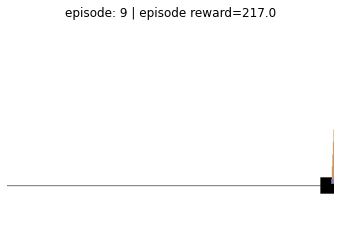

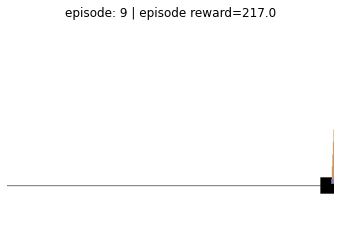

In [12]:
agent.train(max_episodes=10)